In [234]:
import sys
sys.path.insert(0, '../top-k-mallows')
import permutil as pu
import mallows_kendall as mk
import mallows_hamming as mh
import numpy as np
from imp import reload
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import scipy.optimize as opt
import collections

# Learn a DSM, sample a path

In [242]:
def perm_matrix(perm):
  mat = np.zeros((n,n))
  for po, ra in enumerate(perm):
    mat[po,ra]+=1
  return mat
def ds_marginal(perms,weights):
  m = len(perms)
  perm_mats = np.array([perm_matrix(per) for per in perms])
  perm_mats_weight = perm_mats * weights.reshape((m,1,1))
  perm_combination = perm_mats_weight.sum(axis=0)
  return (perm_combination/weights.sum())
def random_tour(mat):
  n,_ = mat.shape
  sigma = np.zeros(n)
  sigma[:] = np.nan
  mask = np.array([True]*n)
  pos = np.random.choice(range(n))
  for i in range(n):
    indices = np.arange(n)[mask]
    probas = mat[pos][mask]
    if probas.sum()== 0 : probas[:] = 1 
    item = np.random.choice(indices, p=probas/probas.sum())
    sigma[pos] = item
    mask[item] = False
    if i != n-1: 
      if  np.isnan(sigma[item])  : pos = item
      else: pos = np.random.choice(np.where(sigma!=sigma)[0])
  return sigma.astype(int)


In [363]:
noise= 0.3
perms = np.array([np.random.permutation(range(n)) for i in range(5)])
weights = np.exp(noise * np.arange(len(perms)))
abs_marg_gt = ds_marginal(perms,weights)
print(perms,"\n")
print(weights.round(3),"\n")
print(perm_matrix(perms[0]),"\n")
print(perm_matrix(perms[1])*weights[1].round(2),"\n")
print(abs_marg_gt.round(3),"\n")

[[2 3 4 1 5 0]
 [3 1 0 2 5 4]
 [1 0 5 2 3 4]
 [3 2 5 1 0 4]
 [5 4 3 2 0 1]] 

[1.    1.35  1.822 2.46  3.32 ] 

[[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]] 

[[0.   0.   0.   1.35 0.   0.  ]
 [0.   1.35 0.   0.   0.   0.  ]
 [1.35 0.   0.   0.   0.   0.  ]
 [0.   0.   1.35 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.35]
 [0.   0.   0.   0.   1.35 0.  ]] 

[[0.    0.183 0.1   0.383 0.    0.334]
 [0.183 0.136 0.247 0.1   0.334 0.   ]
 [0.136 0.    0.    0.334 0.1   0.43 ]
 [0.    0.348 0.652 0.    0.    0.   ]
 [0.581 0.    0.    0.183 0.    0.236]
 [0.1   0.334 0.    0.    0.566 0.   ]] 



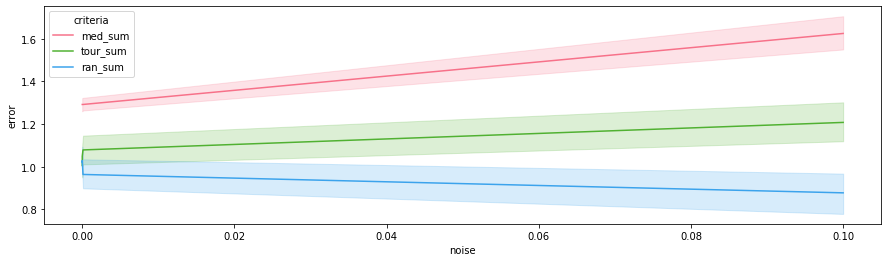

In [352]:
res = []
m_create_synthetic = 100

repes = 10
noise_range= np.logspace(-1,-10,4)

for repe in range(repes):
  perms = np.array([np.random.permutation(range(n)) for i in range(m_create_synthetic)])
  for noise in noise_range:
    weights = np.exp(noise * np.arange(m_create_synthetic))
    abs_marg_gt = ds_marginal(perms,weights)
    median = opt.linear_sum_assignment( - abs_marg_gt )[1]
    ran_tour = random_tour(abs_marg_gt)
    ran = np.random.permutation(range(n))
    a = abs_marg_gt[np.arange(n),median].sum()
    b = abs_marg_gt[np.arange(n),ran_tour].sum()
    c = abs_marg_gt[np.arange(n),ran].sum()
    res.append([repe, noise, a,b,c])

# plt.yscale('log')
plt.figure(figsize=(15,4))
df = pd.DataFrame(res, columns=['repe', 'noise', 'med_sum', 'tour_sum', 'ran_sum'])
df = df.melt(['repe', 'noise'],value_name='error', var_name='criteria')
color_variable='criteria'
palette = sns.color_palette("husl", len(df[color_variable].drop_duplicates()))
sns.lineplot(data=df,x='noise', y='error', hue=color_variable,palette=palette)
